# przygotowanie danych #

In [1]:
import os
import math
from os import walk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
FILE_DIRECTORY =  os.getcwd() + '\\'
DATASET_DIR =  FILE_DIRECTORY + 'DataSet\\UmaFall\\'

file_names = []
dir_names = []

for (dirpath, dirnames, filenames) in walk(DATASET_DIR):
    filenames = [ f for f in filenames if f.endswith('.csv') ]
    file_names.extend(filenames)
    
df_files = pd.DataFrame({'File': file_names})

fn = lambda row: (row.File[19:20])
col = df_files.apply(fn, axis=1)
df_files = df_files.assign(Type=col.values)

df_files = df_files.assign(AccelerometerMax = 0)
df_files = df_files.assign(GyroscopeMax = 0)

df_files.sort_values(by='File', inplace=True, ignore_index=True)
pd.set_option('display.max_rows', df_files.shape[0]+1)
pd.set_option('display.width', 500)
print(df_files.head(30))
print(df_files.tail(30))

                                                 File Type  AccelerometerMax  GyroscopeMax
0   UMAFall_Subject_01_ADL_Aplausing_1_2017-04-14_...    A                 0             0
1   UMAFall_Subject_01_ADL_Aplausing_2_2017-04-14_...    A                 0             0
2   UMAFall_Subject_01_ADL_Aplausing_3_2017-04-14_...    A                 0             0
3   UMAFall_Subject_01_ADL_HandsUp_1_2017-04-14_23...    A                 0             0
4   UMAFall_Subject_01_ADL_HandsUp_2_2017-04-14_23...    A                 0             0
5   UMAFall_Subject_01_ADL_HandsUp_3_2017-04-14_23...    A                 0             0
6   UMAFall_Subject_01_ADL_MakingACall_1_2017-04-1...    A                 0             0
7   UMAFall_Subject_01_ADL_MakingACall_2_2017-04-1...    A                 0             0
8   UMAFall_Subject_01_ADL_MakingACall_3_2017-04-1...    A                 0             0
9   UMAFall_Subject_01_ADL_OpeningDoor_1_2017-04-1...    A                 0             0

# czytanie z plików i przygotowanie atrybutów #

In [3]:
def get_features(df_trials, sensor_name, field_name):
    var_X = df_trials[field_name].var()
    mean_X = df_trials[field_name].mean()
    std_X = df_trials[field_name].std()
    median_X = df_trials[field_name].median()
    max_X = df_trials[field_name].max()
    min_X = df_trials[field_name].min()
    range_X = max_X - min_X
    kurtosis_X = df_trials[field_name].kurtosis()
    skewness_X =  df_trials[field_name].skew()
    
    return pd.DataFrame({"var_" + sensor_name + "_" + field_name: [var_X], 
                                "mean_" + sensor_name + "_" + field_name:[mean_X],
                                "std_" + sensor_name + "_" + field_name:[std_X], 
                                "max_" + sensor_name + "_" + field_name:[max_X],
                                "min_" + sensor_name + "_" + field_name:[min_X], 
                                "range_" + sensor_name + "_" + field_name:[range_X],
                                "kurtosis_" + sensor_name + "_" + field_name:[kurtosis_X],
                                "skewness_" + sensor_name + "_" + field_name:[skewness_X]})  

def compute_trial_file(filename, append_header):
    df_trials = pd.DataFrame(pd.read_csv(filename, header = None, sep = ';', skiprows = 41, usecols = [0, 1, 2, 3, 4, 5, 6],
                                         names = ['Timestamp', 'SampleNo', 'X', 'Y', 'Z', 'SensorType', 'SensorId']))
    
    df_trials = df_trials[df_trials['SensorId'] == 3] # wrist
    df_accelerometer_trials = df_trials[df_trials['SensorType'] == 0]
    df_gyroscope_trials = df_trials[df_trials['SensorType'] == 1]
    
    fn = lambda row : math.sqrt(row.X ** 2 + row.Y ** 2 + row.Z ** 2)
    fn_hor = lambda row: math.sqrt(row.Y ** 2 + row.Z ** 2) # Horizontal
    fn_ver = lambda row: math.sqrt(row.X ** 2 + row.Z ** 2) # Vertical
    
    # Accelerometer
    col = df_accelerometer_trials.apply(fn, axis = 1)
    df_accelerometer_trials = df_accelerometer_trials.assign(N_XYZ = col.values)
    
    # Gyroscope
    col = df_gyroscope_trials.apply(fn, axis = 1)
    df_gyroscope_trials = df_gyroscope_trials.assign(N_XYZ = col.values)
    
    accelerometer_max_N = np.max(df_accelerometer_trials.N_XYZ)
    accelerometer_max_N_index = df_accelerometer_trials.index[df_accelerometer_trials.N_XYZ == accelerometer_max_N][0]
    accelerometer_min_N = np.min(df_accelerometer_trials.N_XYZ)
    accelerometer_min_N_index = df_accelerometer_trials.index[df_accelerometer_trials.N_XYZ == accelerometer_min_N][0]
    
    gyroscope_max_N = np.max(df_gyroscope_trials.N_XYZ)
    gyroscope_max_N_index = df_gyroscope_trials.index[df_gyroscope_trials.N_XYZ == gyroscope_max_N][0]
    gyroscope_min_N = np.min(df_gyroscope_trials.N_XYZ)
    gyroscope_min_N_index = df_gyroscope_trials.index[df_gyroscope_trials.N_XYZ == gyroscope_min_N][0]
    
    len_df_accelerometer_trials = len(df_accelerometer_trials)
    len_df_gyroscope_trials = len(df_gyroscope_trials)
    
    # take 60 measures
    if (accelerometer_max_N_index - 30 < 0):
        df_accelerometer_trials = df_accelerometer_trials[0 : 61]
        print("LOW WINDOW")
    else:
        if (accelerometer_max_N_index + 30 + 1 > len_df_accelerometer_trials):
            df_accelerometer_trials = df_accelerometer_trials[len_df_accelerometer_trials - 62 : len_df_accelerometer_trials - 1]
            print("HIGH WINDOW")
        else:
            df_accelerometer_trials = df_accelerometer_trials[accelerometer_max_N_index - 30 : accelerometer_max_N_index + 30 + 1]
            print("NORMAL WINDOW")
            
    print("accelerometer_max_N = " + str(accelerometer_max_N))
    print("accelerometer_max_N_index = " + str(accelerometer_max_N_index))
    print("accelerometer_min_N = " + str(accelerometer_min_N))
    print("accelerometer_min_N_index = " + str(accelerometer_min_N_index))
    
    if (gyroscope_max_N_index - 30 < 0):
        df_gyroscope_trials = df_gyroscope_trials[0 : 61]
        print("LOW WINDOW")
    else:
        if (gyroscope_max_N_index + 30 + 1 > len_df_gyroscope_trials):
            df_gyroscope_trials = df_gyroscope_trials[len_df_gyroscope_trials - 62 : len_df_gyroscope_trials - 1]
            print("HIGH WINDOW")
        else:
            df_gyroscope_trials = df_gyroscope_trials[gyroscope_max_N_index - 30 : gyroscope_max_N_index + 30 + 1]
            print("NORMAL WINDOW")
            
    print("gyroscope_max_N = " + str(gyroscope_max_N))
    print("gyroscope_max_N_index = " + str(gyroscope_max_N_index))
    print("gyroscope_min_N = " + str(gyroscope_min_N))
    print("gyroscope_min_N_index = " + str(gyroscope_min_N_index))    
           
    # Horizontal axes
    col = df_accelerometer_trials.apply(fn_hor, axis=1)
    df_accelerometer_trials = df_accelerometer_trials.assign(N_HOR = col.values)
    col = df_gyroscope_trials.apply(fn_hor, axis=1)
    df_gyroscope_trials = df_gyroscope_trials.assign(N_HOR = col.values)

    # Vertical axes
    col = df_accelerometer_trials.apply(fn_ver, axis=1)
    df_accelerometer_trials = df_accelerometer_trials.assign(N_VER=col.values)
    col = df_gyroscope_trials.apply(fn_ver, axis=1)
    df_gyroscope_trials = df_gyroscope_trials.assign(N_VER=col.values)
    
    sensor_name = "Accelerometer"
    df_accelerometer_X_features = get_features(df_accelerometer_trials, sensor_name, "X")
    df_accelerometer_Y_features = get_features(df_accelerometer_trials, sensor_name, "Y")
    df_accelerometer_Z_features = get_features(df_accelerometer_trials, sensor_name, "Z")
    df_accelerometer_N_XYZ_features = get_features(df_accelerometer_trials, sensor_name, "N_XYZ")
    df_accelerometer_N_HOR_features = get_features(df_accelerometer_trials, sensor_name, "N_HOR")
    df_accelerometer_N_VER_features = get_features(df_accelerometer_trials, sensor_name, "N_VER")
    sensor_name = "Gyroscope"
    df_gyroscope_X_features = get_features(df_gyroscope_trials, sensor_name, "X")
    df_gyroscope_Y_features = get_features(df_gyroscope_trials, sensor_name, "Y")
    df_gyroscope_Z_features = get_features(df_gyroscope_trials, sensor_name, "Z")
    df_gyroscope_N_XYZ_features = get_features(df_gyroscope_trials, sensor_name, "N_XYZ")
    df_gyroscope_N_HOR_features = get_features(df_gyroscope_trials, sensor_name, "N_HOR")
    df_gyroscope_N_VER_features = get_features(df_gyroscope_trials, sensor_name, "N_VER")  

    df_accelerometer_features = pd.concat([df_accelerometer_X_features,
                              df_accelerometer_Y_features,
                              df_accelerometer_Z_features,
                              df_accelerometer_N_XYZ_features,
                              df_accelerometer_N_HOR_features,
                              df_accelerometer_N_VER_features], axis=1) 

    df_gyroscope_features = pd.concat([df_gyroscope_X_features,
                              df_gyroscope_Y_features,
                              df_gyroscope_Z_features,
                              df_gyroscope_N_XYZ_features,
                              df_gyroscope_N_HOR_features,
                              df_gyroscope_N_VER_features], axis=1)

    df_accelerometer_corr_valueXY = df_accelerometer_trials["X"].corr(df_accelerometer_trials["Y"])
    df_accelerometer_corr_valueXZ = df_accelerometer_trials["X"].corr(df_accelerometer_trials["Z"])
    df_accelerometer_corr_valueYZ = df_accelerometer_trials["Y"].corr(df_accelerometer_trials["Z"])
    df_accelerometer_corr_valueNV = df_accelerometer_trials["N_XYZ"].corr(df_accelerometer_trials["N_VER"])
    df_accelerometer_corr_valueNH = df_accelerometer_trials["N_XYZ"].corr(df_accelerometer_trials["N_HOR"])
    df_accelerometer_corr_valueHV = df_accelerometer_trials["N_HOR"].corr(df_accelerometer_trials["N_VER"])
    df_gyroscope_corr_valueXY = df_gyroscope_trials["X"].corr(df_gyroscope_trials["Y"])
    df_gyroscope_corr_valueXZ = df_gyroscope_trials["X"].corr(df_gyroscope_trials["Z"])
    df_gyroscope_corr_valueYZ = df_gyroscope_trials["Y"].corr(df_gyroscope_trials["Z"])
    df_gyroscope_corr_valueNV = df_gyroscope_trials["N_XYZ"].corr(df_gyroscope_trials["N_VER"])
    df_gyroscope_corr_valueNH = df_gyroscope_trials["N_XYZ"].corr(df_gyroscope_trials["N_HOR"])
    df_gyroscope_corr_valueHV = df_gyroscope_trials["N_HOR"].corr(df_gyroscope_trials["N_VER"])

    df_accelerometer_correlations = pd.DataFrame({"Accelerometer_corr_XY": [df_accelerometer_corr_valueXY],
                                    "Accelerometer_corr_XZ": [df_accelerometer_corr_valueXZ],
                                    "Accelerometer_corr_YZ": [df_accelerometer_corr_valueYZ],
                                    "Accelerometer_corr_NV": [df_accelerometer_corr_valueNV],
                                    "Accelerometer_corr_NH": [df_accelerometer_corr_valueNH], 
                                    "Accelerometer_corr_HV": [df_accelerometer_corr_valueHV]})

    df_gyroscope_correlations = pd.DataFrame({"Gyroscope_corr_XY": [df_gyroscope_corr_valueXY],
                                    "Gyroscope_corr_XZ": [df_gyroscope_corr_valueXZ],
                                    "Gyroscope_corr_YZ": [df_gyroscope_corr_valueYZ],
                                    "Gyroscope_corr_NV": [df_gyroscope_corr_valueNV],
                                    "Gyroscope_corr_NH": [df_gyroscope_corr_valueNH], 
                                    "Gyroscope_corr_HV": [df_gyroscope_corr_valueHV]})  

    trial_file_name = row['File']

    df_file_info = pd.DataFrame({"File": [trial_file_name],
                                  "Action_Type": [trial_file_name[19:20]],
                                  "PersonNo": [trial_file_name[1:3]]})

    df_all_features =  pd.concat([df_file_info, df_accelerometer_features, df_gyroscope_features, df_accelerometer_correlations, df_gyroscope_correlations], axis=1)
    df_accelerometer_features =  pd.concat([df_file_info, df_accelerometer_features, df_accelerometer_correlations], axis=1)
    df_gyroscope_features =  pd.concat([df_file_info, df_gyroscope_features, df_gyroscope_correlations], axis=1)
   
    df_all_features.to_csv(FILE_DIRECTORY + 'prepared_data_full.txt', mode='a', header=True if append_header else False, index=False)
    df_accelerometer_features.to_csv(FILE_DIRECTORY + 'prepared_data_accelerometer.txt', mode='a', header=True if append_header else False, index=False)
    df_gyroscope_features.to_csv(FILE_DIRECTORY + 'prepared_data_gyroscope.txt', mode='a', header=True if append_header else False, index=False)
    
    del df_all_features
    del df_accelerometer_features
    del df_gyroscope_features
    del df_accelerometer_X_features
    del df_accelerometer_Y_features
    del df_accelerometer_Z_features
    del df_accelerometer_N_XYZ_features
    del df_accelerometer_N_HOR_features
    del df_accelerometer_N_VER_features
    del df_gyroscope_X_features
    del df_gyroscope_Y_features
    del df_gyroscope_Z_features
    del df_gyroscope_N_XYZ_features
    del df_gyroscope_N_HOR_features
    del df_gyroscope_N_VER_features
    del df_accelerometer_correlations
    del df_gyroscope_correlations
    del df_file_info
    
    return accelerometer_max_N, accelerometer_max_N_index, accelerometer_min_N, accelerometer_min_N_index, gyroscope_max_N, gyroscope_max_N_index, gyroscope_min_N, gyroscope_min_N_index


"""______________________________________________________________ 

"""
import time
from datetime import timedelta

start_time = time.time()

file_list = df_files[["File"]]
total_num_iter = len(file_list)
iter_no = 1
    
for index, row in file_list.iterrows():
    iter_start_time = time.time()
    
    my_data_file_name = DATASET_DIR + row['File']
    print("_________ ITERATION NO: " + str(iter_no) + "/" + str(total_num_iter) + " (TOTAL)___________________________")
        
    print("_________ PROCESSING TRIAL FILE: " + row['File'] + " ___________________________")
    accelerometer_max_N, accelerometer_max_N_index, accelerometer_min_N, accelerometer_min_N_index, gyroscope_max_N, gyroscope_max_N_index, gyroscope_min_N, gyroscope_min_N_index = compute_trial_file(my_data_file_name, True if iter_no == 1 else False)
    print("________________________________________________________________________________________")    
    elapsed_time_secs = time.time() - iter_start_time
    msg = "Iteration took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))
    print(msg)
    
    iter_no +=1
    remaining_time = round(((time.time() - start_time)/iter_no)*(total_num_iter-iter_no))
    msg = "REMAINING TIME: %s secs (Wall clock time)" % timedelta(seconds = remaining_time)
    print(msg)

    print("________________________________________________________________________________________")    
    

elapsed_time_secs = time.time() - start_time

msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))

print(msg)

_______________________________
_________ ITERATION NO: 701/726 (TOTAL)___________________________
_________ PROCESSING TRIAL FILE: UMAFall_Subject_19_ADL_OpeningDoor_2_2017-04-19_16-55-00.csv ___________________________
HIGH WINDOW
accelerometer_max_N = 1.6952778509440267
accelerometer_max_N_index = 4808
accelerometer_min_N = 0.2517572869057862
accelerometer_min_N_index = 4844
HIGH WINDOW
gyroscope_max_N = 313.87227117460486
gyroscope_max_N_index = 5138
gyroscope_min_N = 3.265092286095257
gyroscope_min_N_index = 5311
________________________________________________________________________________________
Iteration took: 0:00:00 secs (Wall clock time)
REMAINING TIME: 0:00:05 secs (Wall clock time)
________________________________________________________________________________________
_________ ITERATION NO: 702/726 (TOTAL)___________________________
_________ PROCESSING TRIAL FILE: UMAFall_Subject_19_ADL_OpeningDoor_3_2017-04-19_16-55-39.csv ___________________________
HIGH WINDOW
acc

# sprawdzenie poprawności przygotowanych danych #

In [4]:
my_data_file_name = FILE_DIRECTORY + "prepared_data_full.txt"

df_trials = pd.DataFrame(pd.read_csv(my_data_file_name, sep = ','))

df_only_ADLs = df_trials[df_trials.Action_Type == "A"]
df_only_falls = df_trials[df_trials.Action_Type == "F"]

print(df_only_ADLs.tail())
print(df_only_falls.tail())

                                                  File Action_Type PersonNo  var_Accelerometer_X  mean_Accelerometer_X  std_Accelerometer_X  max_Accelerometer_X  min_Accelerometer_X  range_Accelerometer_X  kurtosis_Accelerometer_X  ...  Accelerometer_corr_YZ  Accelerometer_corr_NV  Accelerometer_corr_NH  Accelerometer_corr_HV  Gyroscope_corr_XY  Gyroscope_corr_XZ  Gyroscope_corr_YZ  Gyroscope_corr_NV  Gyroscope_corr_NH  Gyroscope_corr_HV
703  UMAFall_Subject_19_ADL_Sitting_GettingUpOnACha...           A       MA             0.004921             -0.918769             0.070153            -0.752930            -1.072510               0.319580                 -0.452132  ...               0.059140               0.749538               0.629086               0.016648          -0.189839           0.141763           0.036323           0.951360           0.292721           0.079778
704  UMAFall_Subject_19_ADL_Sitting_GettingUpOnACha...           A       MA             0.000589             -0.9324

# atrybuty #

In [5]:
x_columns = ['var_Accelerometer_X','mean_Accelerometer_X','std_Accelerometer_X','max_Accelerometer_X','min_Accelerometer_X','range_Accelerometer_X','kurtosis_Accelerometer_X','skewness_Accelerometer_X',
             'var_Accelerometer_Y','mean_Accelerometer_Y','std_Accelerometer_Y','max_Accelerometer_Y','min_Accelerometer_Y','range_Accelerometer_Y','kurtosis_Accelerometer_Y','skewness_Accelerometer_Y',
             'var_Accelerometer_Z','mean_Accelerometer_Z','std_Accelerometer_Z','max_Accelerometer_Z','min_Accelerometer_Z','range_Accelerometer_Z','kurtosis_Accelerometer_Z','skewness_Accelerometer_Z',
             'var_Accelerometer_N_XYZ','mean_Accelerometer_N_XYZ','std_Accelerometer_N_XYZ','max_Accelerometer_N_XYZ','min_Accelerometer_N_XYZ','range_Accelerometer_N_XYZ','kurtosis_Accelerometer_N_XYZ','skewness_Accelerometer_N_XYZ',
             'var_Accelerometer_N_HOR','mean_Accelerometer_N_HOR','std_Accelerometer_N_HOR','max_Accelerometer_N_HOR','min_Accelerometer_N_HOR','range_Accelerometer_N_HOR','kurtosis_Accelerometer_N_HOR','skewness_Accelerometer_N_HOR',
             'var_Accelerometer_N_VER','mean_Accelerometer_N_VER','std_Accelerometer_N_VER','max_Accelerometer_N_VER','min_Accelerometer_N_VER','range_Accelerometer_N_VER','kurtosis_Accelerometer_N_VER','skewness_Accelerometer_N_VER',
             'var_Gyroscope_X','mean_Gyroscope_X','std_Gyroscope_X','max_Gyroscope_X','min_Gyroscope_X','range_Gyroscope_X','kurtosis_Gyroscope_X','skewness_Gyroscope_X',
             'var_Gyroscope_Y','mean_Gyroscope_Y','std_Gyroscope_Y','max_Gyroscope_Y','min_Gyroscope_Y','range_Gyroscope_Y','kurtosis_Gyroscope_Y','skewness_Gyroscope_Y',
             'var_Gyroscope_Z','mean_Gyroscope_Z','std_Gyroscope_Z','max_Gyroscope_Z','min_Gyroscope_Z','range_Gyroscope_Z','kurtosis_Gyroscope_Z','skewness_Gyroscope_Z',
             'var_Gyroscope_N_XYZ','mean_Gyroscope_N_XYZ','std_Gyroscope_N_XYZ','max_Gyroscope_N_XYZ','min_Gyroscope_N_XYZ','range_Gyroscope_N_XYZ','kurtosis_Gyroscope_N_XYZ','skewness_Gyroscope_N_XYZ',
             'var_Gyroscope_N_HOR','mean_Gyroscope_N_HOR','std_Gyroscope_N_HOR','max_Gyroscope_N_HOR','min_Gyroscope_N_HOR','range_Gyroscope_N_HOR','kurtosis_Gyroscope_N_HOR','skewness_Gyroscope_N_HOR',
             'var_Gyroscope_N_VER','mean_Gyroscope_N_VER','std_Gyroscope_N_VER','max_Gyroscope_N_VER','min_Gyroscope_N_VER','range_Gyroscope_N_VER','kurtosis_Gyroscope_N_VER','skewness_Gyroscope_N_VER',
             'Accelerometer_corr_XY','Accelerometer_corr_XZ','Accelerometer_corr_YZ','Accelerometer_corr_NV','Accelerometer_corr_NH','Accelerometer_corr_HV',
             'Gyroscope_corr_XY','Gyroscope_corr_XZ','Gyroscope_corr_YZ','Gyroscope_corr_NV','Gyroscope_corr_NH','Gyroscope_corr_HV']

x_columns_triaxial = ['var_Accelerometer_X','mean_Accelerometer_X','std_Accelerometer_X','max_Accelerometer_X','min_Accelerometer_X','range_Accelerometer_X','kurtosis_Accelerometer_X','skewness_Accelerometer_X',
             'var_Accelerometer_Y','mean_Accelerometer_Y','std_Accelerometer_Y','max_Accelerometer_Y','min_Accelerometer_Y','range_Accelerometer_Y','kurtosis_Accelerometer_Y','skewness_Accelerometer_Y',
             'var_Accelerometer_Z','mean_Accelerometer_Z','std_Accelerometer_Z','max_Accelerometer_Z','min_Accelerometer_Z','range_Accelerometer_Z','kurtosis_Accelerometer_Z','skewness_Accelerometer_Z',
             'var_Accelerometer_N_XYZ','mean_Accelerometer_N_XYZ','std_Accelerometer_N_XYZ','max_Accelerometer_N_XYZ','min_Accelerometer_N_XYZ','range_Accelerometer_N_XYZ','kurtosis_Accelerometer_N_XYZ','skewness_Accelerometer_N_XYZ',
             'var_Gyroscope_X','mean_Gyroscope_X','std_Gyroscope_X','max_Gyroscope_X','min_Gyroscope_X','range_Gyroscope_X','kurtosis_Gyroscope_X','skewness_Gyroscope_X',
             'var_Gyroscope_Y','mean_Gyroscope_Y','std_Gyroscope_Y','max_Gyroscope_Y','min_Gyroscope_Y','range_Gyroscope_Y','kurtosis_Gyroscope_Y','skewness_Gyroscope_Y',
             'var_Gyroscope_Z','mean_Gyroscope_Z','std_Gyroscope_Z','max_Gyroscope_Z','min_Gyroscope_Z','range_Gyroscope_Z','kurtosis_Gyroscope_Z','skewness_Gyroscope_Z',
             'var_Gyroscope_N_XYZ','mean_Gyroscope_N_XYZ','std_Gyroscope_N_XYZ','max_Gyroscope_N_XYZ','min_Gyroscope_N_XYZ','range_Gyroscope_N_XYZ','kurtosis_Gyroscope_N_XYZ','skewness_Gyroscope_N_XYZ',
             'Accelerometer_corr_XY','Accelerometer_corr_XZ','Accelerometer_corr_YZ',
             'Gyroscope_corr_XY','Gyroscope_corr_XZ','Gyroscope_corr_YZ']

x_columns_V = ['var_Accelerometer_X','mean_Accelerometer_X','std_Accelerometer_X','max_Accelerometer_X','min_Accelerometer_X','range_Accelerometer_X','kurtosis_Accelerometer_X','skewness_Accelerometer_X',
             'var_Accelerometer_Z','mean_Accelerometer_Z','std_Accelerometer_Z','max_Accelerometer_Z','min_Accelerometer_Z','range_Accelerometer_Z','kurtosis_Accelerometer_Z','skewness_Accelerometer_Z',
             'var_Accelerometer_N_VER','mean_Accelerometer_N_VER','std_Accelerometer_N_VER','max_Accelerometer_N_VER','min_Accelerometer_N_VER','range_Accelerometer_N_VER','kurtosis_Accelerometer_N_VER','skewness_Accelerometer_N_VER',
             'var_Gyroscope_X','mean_Gyroscope_X','std_Gyroscope_X','max_Gyroscope_X','min_Gyroscope_X','range_Gyroscope_X','kurtosis_Gyroscope_X','skewness_Gyroscope_X',
             'var_Gyroscope_Z','mean_Gyroscope_Z','std_Gyroscope_Z','max_Gyroscope_Z','min_Gyroscope_Z','range_Gyroscope_Z','kurtosis_Gyroscope_Z','skewness_Gyroscope_Z',
             'var_Gyroscope_N_VER','mean_Gyroscope_N_VER','std_Gyroscope_N_VER','max_Gyroscope_N_VER','min_Gyroscope_N_VER','range_Gyroscope_N_VER','kurtosis_Gyroscope_N_VER','skewness_Gyroscope_N_VER',
             'Accelerometer_corr_XZ','Accelerometer_corr_NV',
             'Gyroscope_corr_XZ','Gyroscope_corr_NV']

x_columns_H = ['var_Accelerometer_Y','mean_Accelerometer_Y','std_Accelerometer_Y','max_Accelerometer_Y','min_Accelerometer_Y','range_Accelerometer_Y','kurtosis_Accelerometer_Y','skewness_Accelerometer_Y',
             'var_Accelerometer_Z','mean_Accelerometer_Z','std_Accelerometer_Z','max_Accelerometer_Z','min_Accelerometer_Z','range_Accelerometer_Z','kurtosis_Accelerometer_Z','skewness_Accelerometer_Z',
             'var_Accelerometer_N_HOR','mean_Accelerometer_N_HOR','std_Accelerometer_N_HOR','max_Accelerometer_N_HOR','min_Accelerometer_N_HOR','range_Accelerometer_N_HOR','kurtosis_Accelerometer_N_HOR','skewness_Accelerometer_N_HOR',
             'var_Gyroscope_Y','mean_Gyroscope_Y','std_Gyroscope_Y','max_Gyroscope_Y','min_Gyroscope_Y','range_Gyroscope_Y','kurtosis_Gyroscope_Y','skewness_Gyroscope_Y',
             'var_Gyroscope_Z','mean_Gyroscope_Z','std_Gyroscope_Z','max_Gyroscope_Z','min_Gyroscope_Z','range_Gyroscope_Z','kurtosis_Gyroscope_Z','skewness_Gyroscope_Z',
             'var_Gyroscope_N_HOR','mean_Gyroscope_N_HOR','std_Gyroscope_N_HOR','max_Gyroscope_N_HOR','min_Gyroscope_N_HOR','range_Gyroscope_N_HOR','kurtosis_Gyroscope_N_HOR','skewness_Gyroscope_N_HOR',
             'Accelerometer_corr_YZ','Accelerometer_corr_NH',
             'Gyroscope_corr_YZ','Gyroscope_corr_NH']

y_column = ["Action_Type"]

In [6]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, f1_score, make_scorer, matthews_corrcoef
from sklearn.model_selection import cross_val_score, cross_val_predict

originalclass = []
predictedclass = []

def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred)

def calc_metrics(clf, X_train, y_tran, linestyle, color, label):
    cross_val_score(clf, X=X_train, y=y_train, cv=10,
                    scoring=make_scorer(classification_report_with_accuracy_score))
    probes = cross_val_predict(clf, X=X_train, y=y_train, cv=10,
                               method='predict_proba')[:, 1]
    print(classification_report(originalclass, predictedclass))
    print('f1 score: ' + str(f1_score(originalclass, predictedclass, pos_label='F')))
    print('matthew cor ef: ' + str(matthews_corrcoef(originalclass, predictedclass)))
    print(metrics.confusion_matrix(originalclass, predictedclass))
 
    fpr, tpr, _ = metrics.roc_curve(y_train, probes, pos_label='F')
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Krzywa ROC')
    plt.plot(fpr, tpr, color, linestyle=linestyle, label=label + ', AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylabel('czułość')
    plt.xlabel('1 - swoistość')
    plt.show()
    
    return probes

              precision    recall  f1-score   support

           A       0.84      0.91      0.87       518
           F       0.72      0.58      0.64       208

    accuracy                           0.81       726
   macro avg       0.78      0.74      0.76       726
weighted avg       0.81      0.81      0.81       726

f1 score: 0.6399999999999999
matthew cor ef: 0.5223215818528468
[[471  47]
 [ 88 120]]


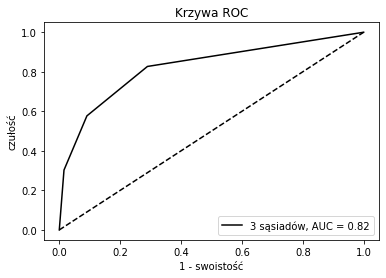

              precision    recall  f1-score   support

           A       0.84      0.92      0.88      1036
           F       0.74      0.55      0.63       416

    accuracy                           0.82      1452
   macro avg       0.79      0.74      0.75      1452
weighted avg       0.81      0.82      0.81      1452

f1 score: 0.6318681318681318
matthew cor ef: 0.5214724977152133
[[954  82]
 [186 230]]


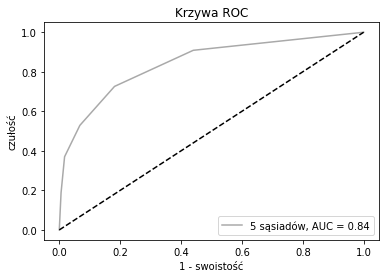

              precision    recall  f1-score   support

           A       0.83      0.93      0.88      1554
           F       0.75      0.54      0.63       624

    accuracy                           0.82      2178
   macro avg       0.79      0.73      0.75      2178
weighted avg       0.81      0.82      0.81      2178

f1 score: 0.6263940520446096
matthew cor ef: 0.5196027539204202
[[1439  115]
 [ 287  337]]


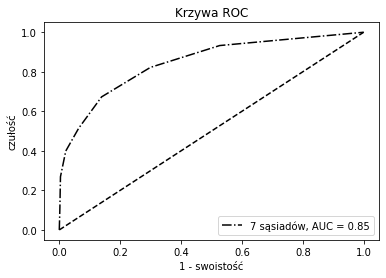

              precision    recall  f1-score   support

           A       0.83      0.94      0.88      2072
           F       0.77      0.51      0.62       832

    accuracy                           0.82      2904
   macro avg       0.80      0.73      0.75      2904
weighted avg       0.81      0.82      0.80      2904

f1 score: 0.6176046176046175
matthew cor ef: 0.521978379738381
[[1946  126]
 [ 404  428]]


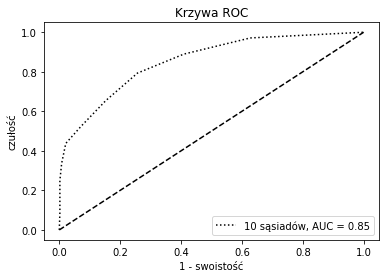

              precision    recall  f1-score   support

           A       0.80      0.95      0.87      2590
           F       0.77      0.41      0.54      1040

    accuracy                           0.80      3630
   macro avg       0.79      0.68      0.70      3630
weighted avg       0.79      0.80      0.77      3630

f1 score: 0.5370138017565872
matthew cor ef: 0.4562399180169776
[[2464  126]
 [ 612  428]]


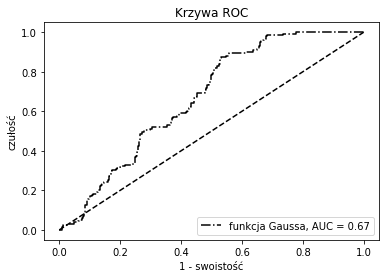

              precision    recall  f1-score   support

           A       0.78      0.96      0.86      3108
           F       0.77      0.34      0.48      1248

    accuracy                           0.78      4356
   macro avg       0.78      0.65      0.67      4356
weighted avg       0.78      0.78      0.75      4356

f1 score: 0.4761904761904761
matthew cor ef: 0.4104137474603891
[[2980  128]
 [ 818  430]]


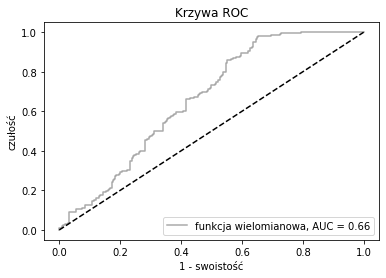

              precision    recall  f1-score   support

           A       0.77      0.96      0.86      3626
           F       0.76      0.30      0.43      1456

    accuracy                           0.77      5082
   macro avg       0.77      0.63      0.64      5082
weighted avg       0.77      0.77      0.73      5082

f1 score: 0.4265215239980208
matthew cor ef: 0.3726040965940752
[[3492  134]
 [1025  431]]


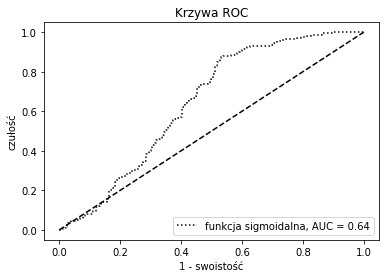

              precision    recall  f1-score   support

           A       0.79      0.96      0.87      4144
           F       0.80      0.35      0.49      1664

    accuracy                           0.79      5808
   macro avg       0.79      0.66      0.68      5808
weighted avg       0.79      0.79      0.76      5808

f1 score: 0.48535564853556473
matthew cor ef: 0.42834862043129984
[[3998  146]
 [1084  580]]


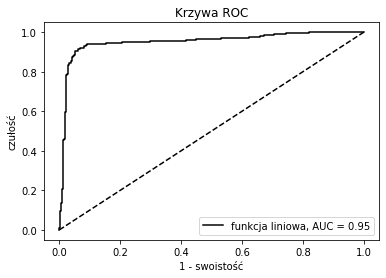

array([1.87792830e-01, 1.73088316e-01, 1.88574982e-01, 1.81645068e-01,
       1.00334849e-01, 2.23885841e-01, 1.15392169e-02, 4.08065078e-02,
       3.71453788e-01, 1.78751179e-01, 1.68639554e-01, 1.58846312e-01,
       1.97187293e-01, 2.02999871e-01, 1.59223021e-01, 1.79590028e-01,
       1.57054813e-01, 3.01753237e-01, 3.16555412e-01, 1.39163644e-01,
       1.27510485e-01, 1.42506871e-01, 1.58361448e-01, 1.80266105e-01,
       3.13372928e-01, 1.31057674e-01, 1.48055197e-01, 1.34339641e-01,
       2.00181338e-01, 1.14461952e-01, 1.29474472e-01, 4.32160194e-02,
       3.87025301e-27, 4.31690047e-27, 8.85423768e-05, 1.04814974e-03,
       8.27471299e-04, 7.55464801e-01, 1.88668511e-04, 2.93868570e-02,
       1.10137161e-01, 1.21562934e-01, 1.41092497e-01, 1.05126702e-01,
       1.20108201e-02, 1.51192657e-01, 1.70815782e-17, 1.35042387e-04,
       4.41456458e-10, 6.76750915e-01, 8.13981924e-01, 6.62265062e-01,
       8.12501669e-01, 7.23777394e-01, 7.31973822e-01, 6.55896651e-01,
      

In [7]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
import numpy as np


knn3 = KNeighborsClassifier(n_neighbors=3)
knn5 = KNeighborsClassifier(n_neighbors=5)
knn7 = KNeighborsClassifier(n_neighbors=7)
knn10 = KNeighborsClassifier(n_neighbors=10)
svm_rbf = SVC(kernel='rbf', random_state=0, max_iter=1000000, probability=True)
svm_poly = SVC(kernel='poly', random_state=0, max_iter=1000000, probability=True)
svm_sigmoid = SVC(kernel='sigmoid', random_state=0, max_iter=1000000, probability=True)
svm_linear = CalibratedClassifierCV(LinearSVC(random_state=0, tol=1e-8, dual=False, max_iter=100000))

classifiers = [knn3, knn5, knn7, knn10, svm_rbf, svm_poly, svm_sigmoid, svm_linear]

x = df_trials[x_columns]
y = df_trials.loc[:,y_column]
y = np.array(y)

knn3.fit(x, y.ravel())
knn5.fit(x, y.ravel())
knn7.fit(x, y.ravel())
knn10.fit(x, y.ravel())
svm_rbf.fit(x, y.ravel())
svm_poly.fit(x, y.ravel())
svm_sigmoid.fit(x, y.ravel())
svm_linear.fit(x, y.ravel())

calc_metrics(knn3, x, y.ravel(), '-', 'black', '3 sąsiadów')
calc_metrics(knn5, x, y.ravel(), '-', 'darkgray', '5 sąsiadów')
calc_metrics(knn7, x, y.ravel(), '-.', 'black', '7 sąsiadów')
calc_metrics(knn10, x, y.ravel(), ':', 'black', '10 sąsiadów')
calc_metrics(svm_rbf, x, y.ravel(), '-.', 'black', 'funkcja Gaussa')
calc_metrics(svm_poly, x, y.ravel(), '-', 'darkgray', 'funkcja wielomianowa')
calc_metrics(svm_sigmoid, x, y.ravel(), ':', 'black', 'funkcja sigmoidalna')
calc_metrics(svm_linear, x, y.ravel(), '-', 'black', 'funkcja liniowa')

In [13]:
from sklearn.metrics import confusion_matrix

i=1
for classifier in classifiers:
    print('klasyfikator numer: ' + str(i))
    predictions = cross_val_predict(classifier, x, y.ravel(), cv=10)
    cm = confusion_matrix(y, predictions, labels=["A", "F"])
    print(cm)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm_norm)
    
    n_TP = cm[1,1]
    n_FP = cm[1,0]
    n_TN = cm[0,0]
    n_FN = cm[0,1]

    # SENSITIVITY = TP / (TP + FN)
    svc_Sensitivity = n_TP / (n_TP + n_FN)
    print("czułość = "+ str(svc_Sensitivity))

    # SPECIFICITY = TN / (FP + TN)
    svc_Specificity = n_TN / (n_FP + n_TN)
    print("swoistość = "+ str(svc_Specificity))

    # Precision = TP / (TP + FP)
    svc_Precision = n_TP / (n_TP + n_FP)
    print("precyzja = "+ str(svc_Precision))

    # Accuracy = (TP + TN) / (TP + FP + TN + FN)
    svc_Accuracy = (n_TP + n_TN) / (n_TP + n_FP + n_TN + n_FN)
    print("dokładność = "+ str(svc_Accuracy))
    i = i + 1

klasyfikator numer: 1
[[471  47]
 [ 88 120]]
[[0.90926641 0.09073359]
 [0.42307692 0.57692308]]
czułość = 0.718562874251497
swoistość = 0.8425760286225402
precyzja = 0.5769230769230769
dokładność = 0.8140495867768595
klasyfikator numer: 2
[[483  35]
 [ 98 110]]
[[0.93243243 0.06756757]
 [0.47115385 0.52884615]]
czułość = 0.7586206896551724
swoistość = 0.8313253012048193
precyzja = 0.5288461538461539
dokładność = 0.8168044077134986
klasyfikator numer: 3
[[485  33]
 [101 107]]
[[0.93629344 0.06370656]
 [0.48557692 0.51442308]]
czułość = 0.7642857142857142
swoistość = 0.8276450511945392
precyzja = 0.5144230769230769
dokładność = 0.8154269972451791
klasyfikator numer: 4
[[507  11]
 [117  91]]
[[0.97876448 0.02123552]
 [0.5625     0.4375    ]]
czułość = 0.8921568627450981
swoistość = 0.8125
precyzja = 0.4375
dokładność = 0.8236914600550964
klasyfikator numer: 5
[[518   0]
 [208   0]]
[[1. 0.]
 [1. 0.]]
czułość = nan
swoistość = 0.7134986225895317
precyzja = 0.0
dokładność = 0.71349862258953

In [11]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
import numpy as np

for i in range(1, 100):
    classifier = KNeighborsClassifier(n_neighbors=i)

    x = df_trials[x_columns]
    y = df_trials.loc[:,y_column]
    y = np.array(y)

    classifier.fit(x, y.ravel())
    
    predictions = cross_val_predict(classifier, x, y.ravel(), cv=10)
    cm = confusion_matrix(y, predictions, labels=["A", "F"])
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    n_TP = cm[1,1]
    n_FP = cm[1,0]
    n_TN = cm[0,0]
    n_FN = cm[0,1]

    # SENSITIVITY = TP / (TP + FN)
    svc_Sensitivity = n_TP / (n_TP + n_FN)
    # SPECIFICITY = TN / (FP + TN)
    svc_Specificity = n_TN / (n_FP + n_TN)
    # Precision = TP / (TP + FP)
    svc_Precision = n_TP / (n_TP + n_FP)
    # Accuracy = (TP + TN) / (TP + FP + TN + FN)
    svc_Accuracy = (n_TP + n_TN) / (n_TP + n_FP + n_TN + n_FN)

    print(str(i)+','+str(svc_Sensitivity)+','+str(svc_Specificity)+','+str(svc_Precision)+','+str(svc_Accuracy))

1,0.6565656565656566,0.8522727272727273,0.625,0.7988980716253443
2,0.8130841121495327,0.8045234248788369,0.4182692307692308,0.8057851239669421
3,0.718562874251497,0.8425760286225402,0.5769230769230769,0.8140495867768595
4,0.8468468468468469,0.8146341463414634,0.4519230769230769,0.8195592286501377
5,0.7586206896551724,0.8313253012048193,0.5288461538461539,0.8168044077134986
6,0.8256880733944955,0.8087520259319287,0.4326923076923077,0.8112947658402204
7,0.7642857142857142,0.8276450511945392,0.5144230769230769,0.8154269972451791
8,0.8532110091743119,0.813614262560778,0.44711538461538464,0.8195592286501377
9,0.8076923076923077,0.8271812080536913,0.5048076923076923,0.8236914600550964
10,0.8921568627450981,0.8125,0.4375,0.8236914600550964
11,0.825,0.8201320132013201,0.47596153846153844,0.8209366391184573
12,0.8969072164948454,0.8076311605723371,0.4182692307692308,0.8195592286501377
13,0.8495575221238938,0.8172920065252854,0.46153846153846156,0.8223140495867769
14,0.9081632653061225,0.8105095